In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
import seaborn as sns
from matplotlib.animation import FuncAnimation
from fbm import FBM

In [ ]:
available_pairs = ['EURUSD', 'GBPUSD', 'AUDJPY', 'USDJPY']
pip_sizes = [0.0001,0.0001,0.01,0.01]
freq = ["M1","M5","M15","M30","H1","H4","D1"]

def_freq = freq[0]
def_pair = available_pairs[0]

def get_raw_forex_data(pair,frequency):
    data = pd.read_csv(rf"ALAMforForex\Forex\{pair}_{frequency}.csv",delimiter="\t")
    data.columns = ["Open","High","Low","Close","Volume","Spread"]
    return data

def get_smooth_forex_data(pair,frequency,smoothness):
    data = pd.read_csv(f"ALAMforForex\Forex\{pair}_{frequency}.csv",delimiter="\t")
    data.columns = ["Open","High","Low","Close","Volume","Spread"]
    data_raw = data["Close"]
    data_smooth = data_raw.rolling(window=50).mean().dropna()
    
    x = np.arange(len(data_smooth))
    #p= np.polyfit(x,data_smooth, 32)
    #fit_line = np.polyval(p,x)
    return (x,data_smooth)


FileNotFoundError: [Errno 2] No such file or directory: 'ALAMforForex\\Forex\\EURUSD_M1.csv'

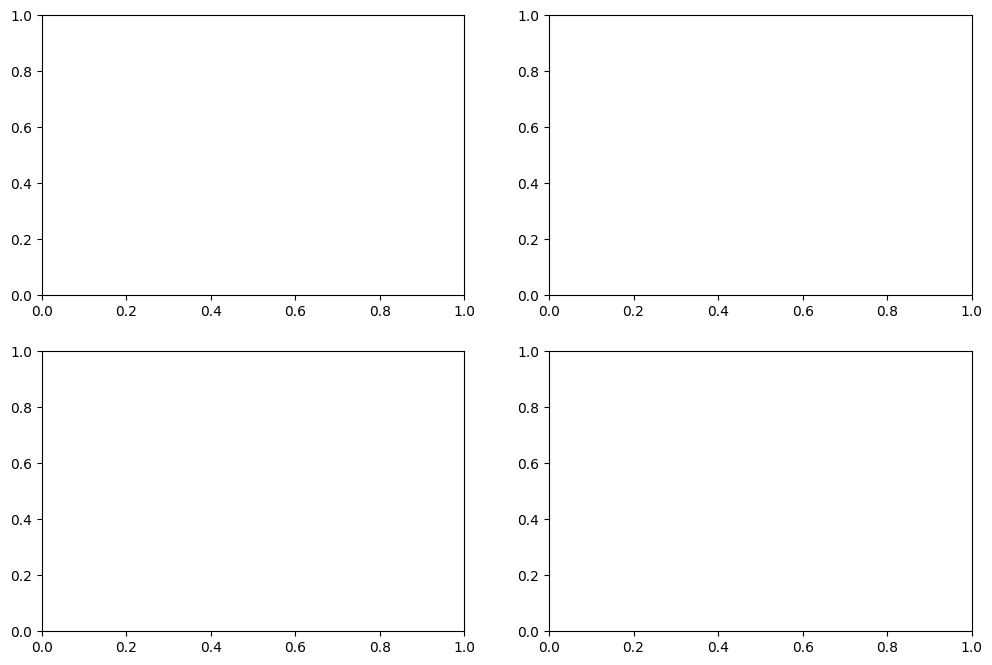

In [3]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i,pair in enumerate(available_pairs):
    ax = axs[i // 2, i % 2]
    (ax.plot(get_smooth_forex_data(pair,def_freq,0)[0],get_smooth_forex_data(pair,def_freq,0)[1],label=pair))
    ax.set_title(f'{pair} Prices');ax.set_xlabel('Time (dt = 1minute)');ax.set_ylabel(f'Price({pair[:3]})')
    ax.grid();ax.legend()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
def simulute_10_liquidity_providers(pair,freq,pip_size):
    qty_lps = 10
    base_price = (get_raw_forex_data(pair,freq)["Close"]).iloc[-1]
    avg_spread = (get_raw_forex_data(pair,freq)["Spread"].mean())*pip_size
    sigma = np.std(get_raw_forex_data(pair,freq)["Spread"])*pip_size
    LP_data = [] 
    for i in range(qty_lps):
        LP_ID = i+1
        spread_noise = abs(np.random.normal(0,sigma))
        spread_incr = LP_ID**0.75
        bid = round(base_price - spread_incr*(avg_spread/2+spread_noise),4)
        ask = round(base_price + spread_incr*(avg_spread/2+spread_noise),4)
        LP_data.append({"LP":f"LP_{LP_ID}","Spread":round(ask-bid,5),"Bid":bid,"Ask":ask})
    return LP_data
LP_data = simulute_10_liquidity_providers(def_pair,def_freq,pip_sizes[0])
LP_data

[{'LP': 'LP_1', 'Spread': 0.0014, 'Bid': 1.0862, 'Ask': 1.0876},
 {'LP': 'LP_2', 'Spread': 0.002, 'Bid': 1.0859, 'Ask': 1.0879},
 {'LP': 'LP_3', 'Spread': 0.0009, 'Bid': 1.0865, 'Ask': 1.0874},
 {'LP': 'LP_4', 'Spread': 0.0045, 'Bid': 1.0847, 'Ask': 1.0892},
 {'LP': 'LP_5', 'Spread': 0.0013, 'Bid': 1.0863, 'Ask': 1.0876},
 {'LP': 'LP_6', 'Spread': 0.0053, 'Bid': 1.0843, 'Ask': 1.0896},
 {'LP': 'LP_7', 'Spread': 0.0045, 'Bid': 1.0847, 'Ask': 1.0892},
 {'LP': 'LP_8', 'Spread': 0.01, 'Bid': 1.0819, 'Ask': 1.0919},
 {'LP': 'LP_9', 'Spread': 0.0069, 'Bid': 1.0835, 'Ask': 1.0904},
 {'LP': 'LP_10', 'Spread': 0.0055, 'Bid': 1.0842, 'Ask': 1.0897}]

Let's simulate a further 120 minutes (2 hours), since this likely encompasses most liquidity aggregators hedging periods.

To create an accurate forecast we first need to uncover some properties using Time Series Analysis.

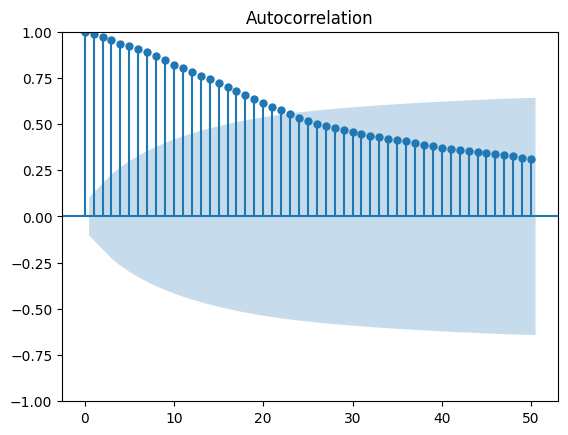

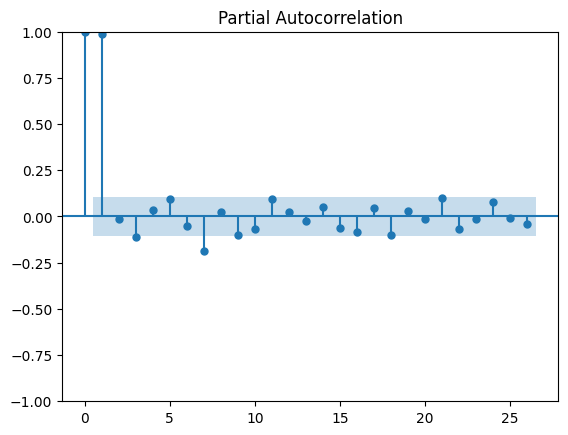

In [ ]:
horizon = 60*2
history = 60*6
TS_lastsixhour = (get_raw_forex_data(def_pair,def_freq)["Close"])[-history:]
TS_lastsixhour.index = pd.to_datetime(TS_lastsixhour.index)
n = horizon + len(TS_lastsixhour)
last_value = TS_lastsixhour.iloc[-1]  # Get the last yhat value

plot_acf(TS_lastsixhour,lags=50);
plot_pacf(TS_lastsixhour);


In [ ]:
model = ARIMA(TS_lastsixhour, order=(22, 0, 2))
fitted_model = model.fit()
forecast = fitted_model.simulate(nsimulations=horizon)
forecast = np.concatenate(([last_value],forecast))

simulated_time_index = pd.date_range(start=TS_lastsixhour.index[-1] + pd.DateOffset(minutes=1), periods=horizon+1, freq='T')
FCST_df = pd.DataFrame((pd.to_datetime(simulated_time_index),np.round(forecast,5))).T
FCST_df.columns = ["ds","y"]
DF_lastsixhour = pd.DataFrame((TS_lastsixhour.index,TS_lastsixhour)).T
DF_lastsixhour.columns = ["ds","y"]



C:\Users\dbjac\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
C:\Users\dbjac\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
C:\Users\dbjac\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
C:\Users\dbjac\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\dbjac\AppData\Local\Temp\ipykernel_21528\947164557.py:6: FutureWarnin

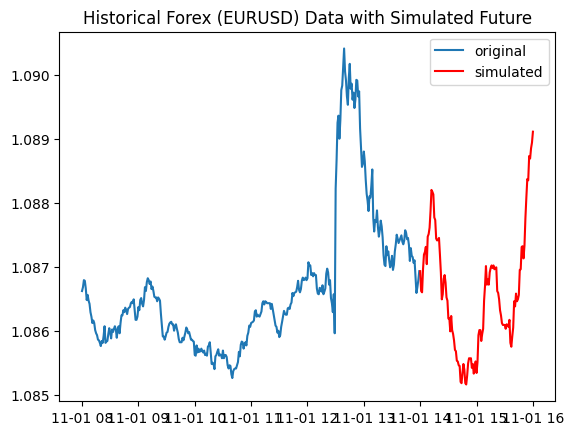

In [ ]:
plt.plot(DF_lastsixhour["ds"],DF_lastsixhour["y"],label="original")
plt.plot(FCST_df["ds"],FCST_df["y"],color="red",label="simulated")
plt.title(f"Historical Forex ({def_pair}) Data with Simulated Future")
plt.legend()

121
121


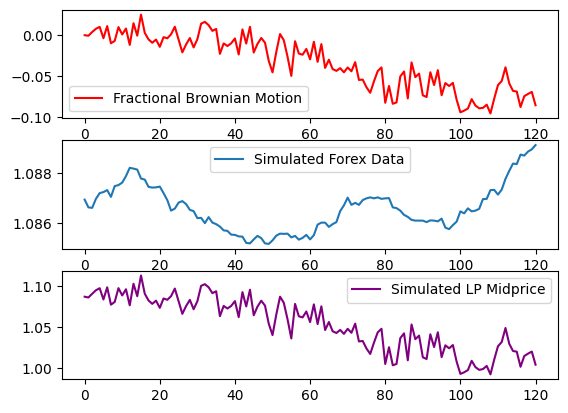

In [ ]:
fig, axes = plt.subplots(3,1,)
f = FBM(n=120, hurst=0.3, length=pip_sizes[0])
smooth_random_series = f.fbm()
axes[0].plot(smooth_random_series,label="Fractional Brownian Motion",color="red")
axes[0].legend()

axes[1].plot(FCST_df["y"],label="Simulated Forex Data")
axes[1].legend()

random_mid = FCST_df["y"].values + smooth_random_series
axes[2].plot(random_mid,label="Simulated LP Midprice",color="purple")
axes[2].legend()

print(len(FCST_df["y"]))
print(len(smooth_random_series))

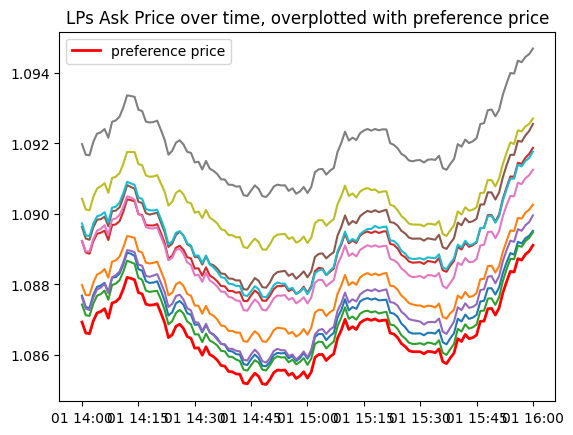

In [ ]:
def live_simulute_liquidity_providers(LP_data,simulated_data,pip_sizes,init_cash):
    results = []
    
    spread_scale = (pip_sizes/100)*init_cash
    max_spread = np.max([LP["Spread"] for LP in LP_data])
    min_spread = np.min([LP["Spread"] for LP in LP_data])
    for i,LP in enumerate(LP_data):
        f = FBM(n=120, hurst=0.8, length=pip_sizes)
        smooth_random_series = f.fbm()
        spreads = []
        lp_evolution = []
        mids = (simulated_data["y"].values + smooth_random_series) + spread_scale
        base_spread = LP["Spread"]
        for t,price_points in enumerate(simulated_data["y"]):
            ask = mids[t] + base_spread/2 
            bid = ask - base_spread
            spreads.append(ask-bid)
            base_price = price_points
            lp_evolution.append({"LP":i+1,"Price":base_price,"Spread":ask-bid,"Bid":bid,"Ask":ask,"Mid":mids[t],"Residual":ask-base_price})
        results.append(lp_evolution)
    return results

init_cash = 50
simulated_data = FCST_df
lp_results = live_simulute_liquidity_providers(LP_data,simulated_data,pip_sizes[0],init_cash)

for lp_evolution in lp_results:
    asks = [entry["Ask"] for entry in lp_evolution]  
    plt.plot(FCST_df["ds"], asks)  
    #bids = [entry["Bid"] for entry in lp_evolution]  
    #plt.plot(FCST_df["ds"], bids) 
plt.plot(FCST_df["ds"],FCST_df["y"],color="red",lw=2,label="preference price")
plt.title("LPs Ask Price over time, overplotted with preference price")
plt.legend()

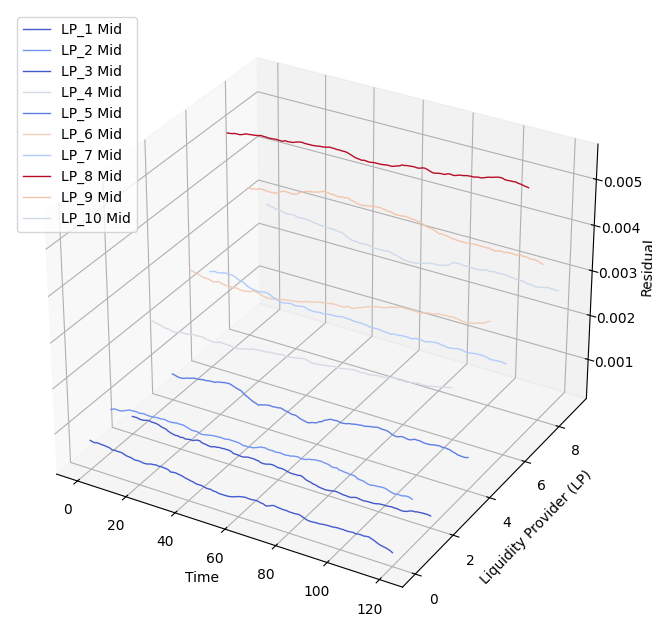

In [ ]:
def plot_liquidity_provider_spreads(results):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    all_res = [entry['Residual'] for lp_data in results for entry in lp_data]
    norm = mcolors.Normalize(vmin=min(all_res), vmax=max(all_res))
    colormap = plt.cm.coolwarm

    for i, lp_data in enumerate(results):
        time_points = range(len(lp_data))
        res_values = [entry['Residual'] for entry in lp_data]
        bid_values = [entry['Bid'] for entry in lp_data]
        ask_values = [entry['Ask'] for entry in lp_data]
        mids = [(bid + ask) / 2 for bid, ask in zip(bid_values, ask_values)]

        colors = colormap(norm(res_values))
        ax.plot(time_points, [i]*len(time_points), res_values,color=colors[-1] ,label=f"LP_{i+1} Mid",lw=1)

        # Optionally, plot Bid and Ask over time as separate lines for each LP
        #ax.plot(time_points, [i]*len(time_points), bid_values,color=colors[-1] ,linestyle="--" )
        #ax.plot(time_points, [i]*len(time_points), ask_values,color=colors[-1] ,linestyle="--")

    ax.set_xlabel('Time')
    ax.set_ylabel('Liquidity Provider (LP)')
    ax.set_zlabel('Residual')
    ax.legend()
    plt.show()

plot_liquidity_provider_spreads(lp_results)


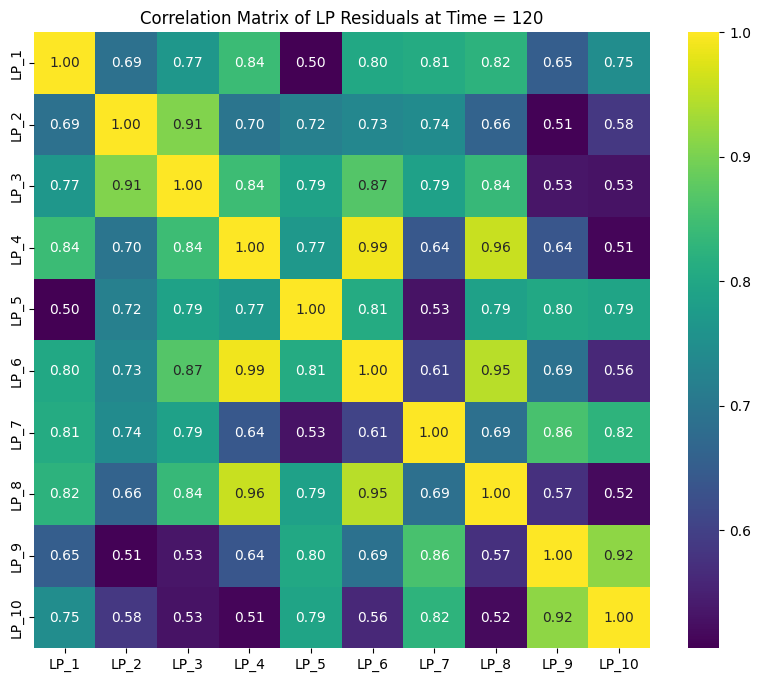

In [ ]:
corr_matrices_all = []
for time_step in lp_results:
    residuals = []
    for lp_entry in time_step:
        lp_name = lp_entry["LP"]
        residual = lp_entry['Residual']
        residuals.append({'LP': lp_name, 'Residual': residual})
  
    df = residuals
    corr_matrices_all.append(df)

residual_columnised = pd.DataFrame(columns=["LP_1", "LP_2", "LP_3", "LP_4", "LP_5", "LP_6", "LP_7", "LP_8", "LP_9", "LP_10"])
index = 0
for LP in corr_matrices_all:
    col_dat = []
    for time_step in LP:
        col_dat.append(time_step["Residual"])
    residual_columnised[f"LP_{index+1}"] = col_dat
    index += 1

cumulative_corr_matrices = []

for i in range(1, len(residual_columnised) + 1):
    if i == 1 or i == 2:
            correlation_matrix = pd.DataFrame(0, index=residual_columnised.columns, columns=residual_columnised.columns)
    else:
        cumulative_data = residual_columnised.iloc[:i]
        correlation_matrix = cumulative_data.corr().abs()
        correlation_matrix = (correlation_matrix + 1) / 2
    cumulative_corr_matrices.append(correlation_matrix)


plt.figure(figsize=(10, 8))
sns.heatmap(cumulative_corr_matrices[-1], annot=True, fmt=".2f", cmap="viridis", square=True)
plt.title(f'Correlation Matrix of LP Residuals at Time = {horizon}')
plt.show()



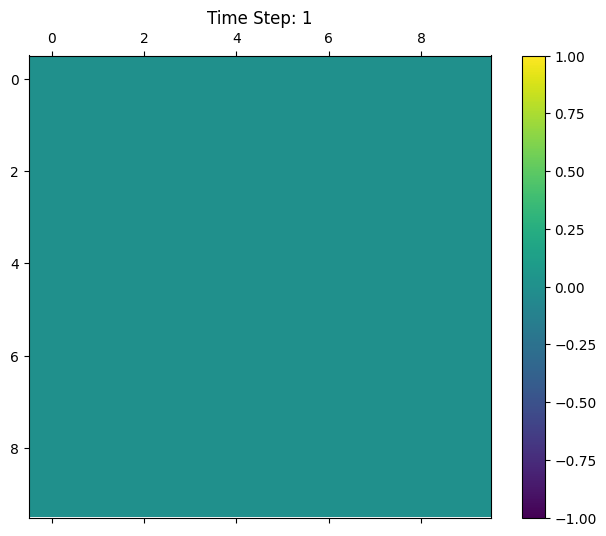

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(np.zeros((10, 10)), cmap="viridis", vmin=-1, vmax=1)
def update(frame):
    corr_matrix = cumulative_corr_matrices[frame]
    ax.clear()
    ax.matshow(corr_matrix, cmap="viridis", vmin=-1, vmax=1)
    ax.set_title(f"Time Step: {frame + 1}")
    
fig.colorbar(cax)
anim = FuncAnimation(fig, update, frames=len(cumulative_corr_matrices), interval=500, repeat=False)
anim.save('correlation_animation.gif', writer='pillow') 


![Liquidity Correlation GIF](correlation_animation.gif)


In [ ]:
(cumulative_corr_matrices[4].mean(axis=0).values)[3]

0.9115508066796043

In [ ]:
def optimal_evolutions(residual_columnised,cumulative_corr_matrices,num_to_select=5):
    optimal_allocations = []
    for i in range(len(residual_columnised)):
        LP_score = []
        for LP in residual_columnised:
            corr_index = int((LP.split("_")[1]))
            res_score = residual_columnised[LP][i]
            corr_scores = (cumulative_corr_matrices[i].mean(axis=0).values)
            corr_scores = corr_scores[corr_index-1]
            res_normed = (res_score-min(residual_columnised[LP]))/(max(residual_columnised[LP])-min(residual_columnised[LP]))
            total_score = (-res_normed)+(-corr_scores)
            LP_score.append(total_score)
        LP_sorted = np.argsort(LP_score)[:3]
        optimal_allocations.append(LP_sorted)
    return optimal_allocations

optimal_allocations = optimal_evolutions(residual_columnised,cumulative_corr_matrices,num_to_select=5)
optimal_allocations[:10]

[array([0, 9, 2], dtype=int64),
 array([0, 2, 9], dtype=int64),
 array([2, 0, 9], dtype=int64),
 array([9, 0, 6], dtype=int64),
 array([9, 6, 2], dtype=int64),
 array([6, 9, 2], dtype=int64),
 array([6, 9, 0], dtype=int64),
 array([6, 2, 0], dtype=int64),
 array([6, 2, 0], dtype=int64),
 array([6, 2, 0], dtype=int64)]

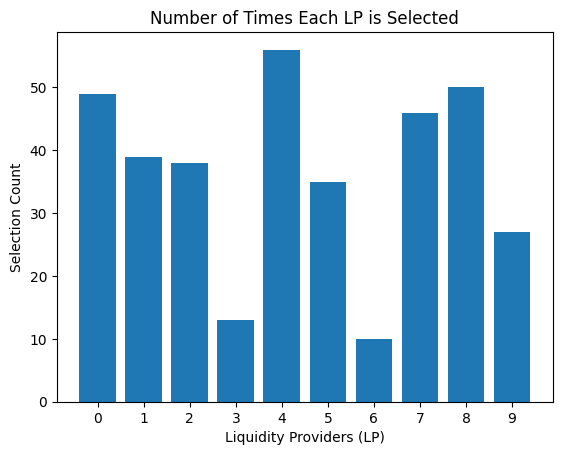

In [ ]:

# Create a dictionary to count the number of times each LP is selected
lp_counts = {f"{i}": 0 for i in range(10)}  # Assuming 10 LPs

# Count the occurrences of each LP in the optimal allocations
for allocation in optimal_allocations:
    for lp in allocation:
        lp_counts[f"{lp}"] += 1

# Plot the occurrences of each LP being selected over time
plt.bar(lp_counts.keys(), lp_counts.values())
plt.title("Number of Times Each LP is Selected")
plt.xlabel("Liquidity Providers (LP)")
plt.ylabel("Selection Count")
plt.show()


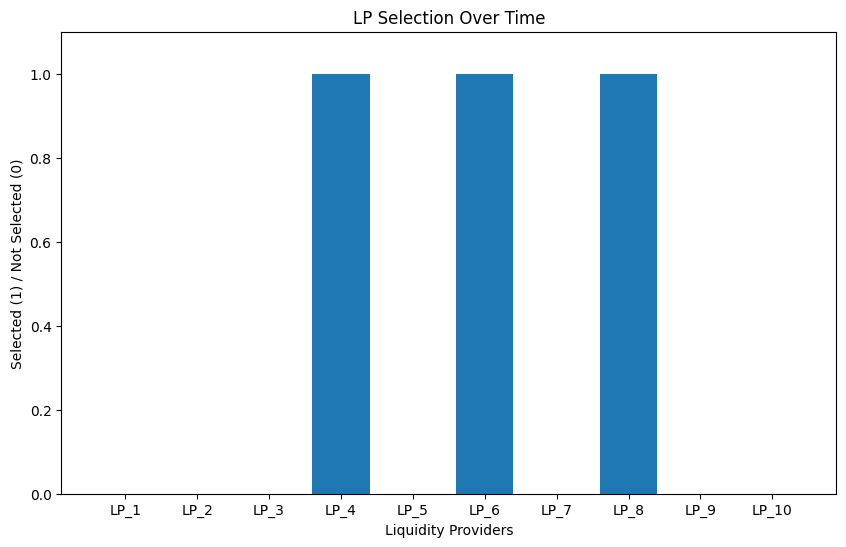

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

# Initialize bars: LPs (LP_1, LP_2, ..., LP_10)
lp_labels = [f"LP_{i+1}" for i in range(10)]
bars = ax.bar(lp_labels, [0] * 10)  # Initially set all bars to 0

# Set up the labels and title
ax.set_ylim(0, 1.1)  # To show the bar height from 0 to 1
ax.set_title('LP Selection Over Time')
ax.set_xlabel('Liquidity Providers')
ax.set_ylabel('Selected (1) / Not Selected (0)')

# Function to update the plot at each time step
def update(frame):
    # Create a list of 0s and 1s for each LP indicating whether it is selected
    selection = [1 if i in optimal_allocations[frame] else 0 for i in range(10)]
    
    # Update the bar heights
    for i, bar in enumerate(bars):
        bar.set_height(selection[i])  # Set the bar height to 1 if selected, else 0

# Create an animation
anim = FuncAnimation(fig, update, frames=len(optimal_allocations), interval=500, repeat=False)
anim.save('LiquidityAllocation.gif', writer='pillow')
# Display the animation
plt.show()